In [1]:
import numpy as np

#from assets.keras.keras.datasets import shapes_3d
from assets.keras.keras.preprocessing.image import ImageDataGenerator
from assets.keras.keras.models import Sequential
from assets.keras.keras.layers.core import Dense, Dropout, Activation, Flatten
from assets.keras.keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
from assets.keras.keras.layers.normalization import BatchNormalization
from assets.keras.keras.optimizers import SGD, RMSprop, Adam
from assets.keras.keras.utils import np_utils, generic_utils
from assets.keras.keras.regularizers import l2
from assets.keras.keras.callbacks import EarlyStopping
import theano
import matplotlib.pyplot as plt
import math
from assets.vis_utils import *
%matplotlib nbagg
%load_ext autoreload
%autoreload 2

#load dataset from gen_dataset
import cPickle as pickle

Using Theano backend.
/root/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Couldn't import dot_parser, loading of dot files will not be possible.


Using Theano backend.


In [2]:
from assets.gen_motion import gen_dataset
import math

angles = [0,math.pi/4,math.pi/2,math.pi*3/4,math.pi,math.pi*5/4,math.pi*3/2,math.pi*7/4]
#gen_dataset(size, N, obj_type, obj_theta, obj_vel, types, velocity, theta, coherence, dots, directions(opt))
X_train,Y_train,X_val,Y_val,X_test,Y_test = gen_dataset((16,32,32),50,None,['translate'],[1],angles,[1],[150],[0])

Y_train[:,2] = Y_train[:,2]/math.pi*4
Y_val[:,2] = Y_val[:,2]/math.pi*4
Y_test[:,2] = Y_test[:,2]/math.pi*4

##### WARNING ##########################################
# CHANGE THIS CODE IF YOU CHANGE THE NUMBER OF CLASSES #
######################################## WARNING #######
nb_classes = len(angles)
Y_train = np_utils.to_categorical(Y_train[:,2]-1, nb_classes)
Y_val = np_utils.to_categorical(Y_val[:,2]-1,nb_classes)
Y_test = np_utils.to_categorical(Y_test[:,2]-1, nb_classes)

In [3]:
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_val shape:', X_val.shape)
print('Y_val shape:', Y_val.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'val samples')
print(X_test.shape[0], 'test samples')

('X_train shape:', (400, 1, 16, 32, 32))
('Y_train shape:', (400, 8))
('X_val shape:', (40, 1, 16, 32, 32))
('Y_val shape:', (40, 8))
('X_test shape:', (40, 1, 16, 32, 32))
('Y_test shape:', (40, 8))
(400, 'train samples')
(40, 'val samples')
(40, 'test samples')


In [4]:
def build_eval(params,r,l,nb_f,nb_p,nb_c,data,model):
    batch_size, nb_classes, nb_epoch = params
    X_train,Y_train,X_val,Y_val,X_test,Y_test = data
    if model==None:
        model = Sequential()
        model.add(ZeroPadding3D((0,1,1),input_shape=(1,16,32,32)))
        model.add(Convolution3D(nb_f[0],len_conv_dim1=1, len_conv_dim2=nb_c[0], len_conv_dim3=nb_c[0], border_mode='valid',
                                 activation='relu', W_regularizer=l2(r),dim_ordering='th',name='LGN'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(1, nb_p[0], nb_p[0])))
        #model.add(Dropout(0.5))
        model.add(ZeroPadding3D((1,1,1)))
        model.add(Convolution3D(nb_f[1],len_conv_dim1=nb_c[1], len_conv_dim2=nb_c[1], len_conv_dim3=nb_c[1], border_mode='valid',
                                activation='relu', W_regularizer=l2(r), name='V1'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(nb_p[1], nb_p[1], nb_p[1])))
        #model.add(Dropout(0.5))
        #model.add(ZeroPadding3D((1,1,1)))
        model.add(Convolution3D(nb_f[2],len_conv_dim1=nb_c[2], len_conv_dim2=nb_c[2], len_conv_dim3=nb_c[2], border_mode='valid',
                                activation='relu', W_regularizer=l2(r), name='MT'))
        model.add(BatchNormalization())
        model.add(Flatten())
        #model.add(Dropout(0.5))
        #model.add(Dense(4, init='normal', activation='relu', W_regularizer=l2(reg)))
        model.add(Dense(nb_classes, init='normal', W_regularizer=l2(r)))
        model.add(Activation('softmax'))

        #Adam
        sgd = RMSprop(lr=l, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd, class_mode='categorical')

        
    # control the model to crash early if nothing happens
    earlyStopping=EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')

    hist = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch, show_accuracy=True, verbose=1,
              validation_data=(X_val,Y_val), callbacks=[earlyStopping])
    scoretr = model.evaluate(X_train, Y_train, batch_size=batch_size, show_accuracy=True)
    scoreva = model.evaluate(X_val, Y_val, batch_size=batch_size, show_accuracy=True)
    return (model, hist, scoretr, scoreva)

In [5]:
iters = 1

data = (X_train,Y_train,X_val,Y_val,X_test,Y_test)

best_model = None
best_val = 0
best_hist = None
best_scoretr = None
best_scoreva = None
best_params = None


batch_size = 20
nb_epoch = 20

params = (batch_size,nb_classes,nb_epoch)

for i in range(iters):
    # for each iteration
    print 'Training model #: ', i+1
    nb_filters = [4,4,4] #[2**np.random.randint(2,3),2**np.random.randint(2,3),2**np.random.randint(2,3)]
    nb_pool = [2,2]
    nb_conv = [3,3,3]
    reg = 1e-3#10**(-1*np.random.rand()*2)
    l_r = 1e-3#10**(-1*(np.random.rand()*2+4))
    model,hist,scoretr,scoreva = build_eval(params,reg,l_r,nb_filters,nb_pool,nb_conv,data,None)
    if scoreva[1] > best_val:
        best_model = model
        best_hist = hist
        best_scoretr = scoretr
        best_scoreva = scoreva
        best_val = scoreva[1]
        best_params = (reg,l_r,nb_filters,nb_pool,nb_conv)
    

Training model #:  1
Train on 400 samples, validate on 40 samples
Epoch 1/20
400/400 [==============================] - 4s - loss: 2.1159 - acc: 0.1300 - val_loss: 2.0796 - val_acc: 0.1250
Epoch 2/20
400/400 [==============================] - 4s - loss: 2.0732 - acc: 0.2850 - val_loss: 2.0692 - val_acc: 0.1250
Epoch 3/20
400/400 [==============================] - 4s - loss: 1.9596 - acc: 0.4475 - val_loss: 1.9076 - val_acc: 0.4000
Epoch 4/20
400/400 [==============================] - 4s - loss: 1.7093 - acc: 0.6150 - val_loss: 1.6357 - val_acc: 0.4500
Epoch 5/20
400/400 [==============================] - 4s - loss: 1.4233 - acc: 0.7075 - val_loss: 1.3639 - val_acc: 0.6250
Epoch 6/20
400/400 [==============================] - 4s - loss: 1.1298 - acc: 0.8375 - val_loss: 1.1705 - val_acc: 0.5000
Epoch 7/20
400/400 [==============================] - 4s - loss: 0.8555 - acc: 0.8900 - val_loss: 0.8587 - val_acc: 0.7250
Epoch 8/20
400/400 [==============================] - 4s - loss: 0.6422 -

In [6]:
scorete = best_model.evaluate(X_test, Y_test, batch_size=20, show_accuracy=True)

print('Train loss:', best_scoretr[0])
print('Train accuracy:', best_scoretr[1])
print('Val loss:', best_scoreva[0])
print('Val accuracy:', best_scoreva[1])
print('Test loss:', scorete[0])
print('Test accuracy:', scorete[1])

print best_params

40/40 [==============================] - 0s     
('Train loss:', 0.018897480284795164)
('Train accuracy:', 1.0)
('Val loss:', 0.12612170353531837)
('Val accuracy:', 0.92500000000000004)
('Test loss:', 0.040838390588760376)
('Test accuracy:', 1.0)
(0.001, 0.001, [4, 4, 4], [2, 2], [3, 3, 3])


<IPython.core.display.Javascript object>


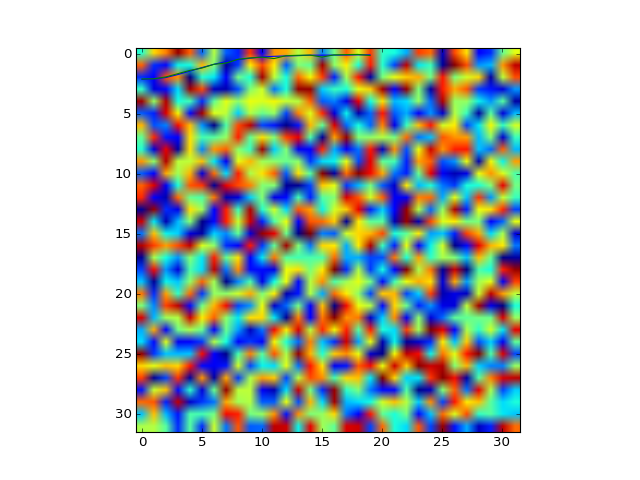

In [7]:
#print best_model.history.history.keys()
plt.plot(np.asarray(best_model.history.history['loss'])[0:500])
plt.plot(np.asarray(best_model.history.history['val_loss'])[0:500])

In [30]:
# (#outputs,#inputs,time,x-dir,y-dir)
for layer in model.layers:
    g = layer.get_config()
    h = layer.get_weights()
    #print g
    for hi in h:
        #print hi
        print hi.shape

(4, 1, 1, 3, 3)
(4,)
(32,)
(32,)
(32,)
(32,)
(4, 4, 3, 3, 3)
(4,)
(16,)
(16,)
(16,)
(16,)
(4, 4, 3, 3, 3)
(4,)
(6,)
(6,)
(6,)
(6,)
(864, 8)
(8,)


In [13]:
from assets.validation import *

<IPython.core.display.Javascript object>


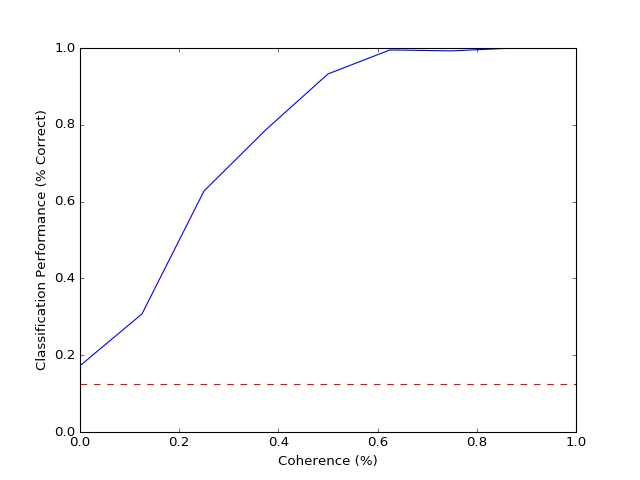

<IPython.core.display.Javascript object>


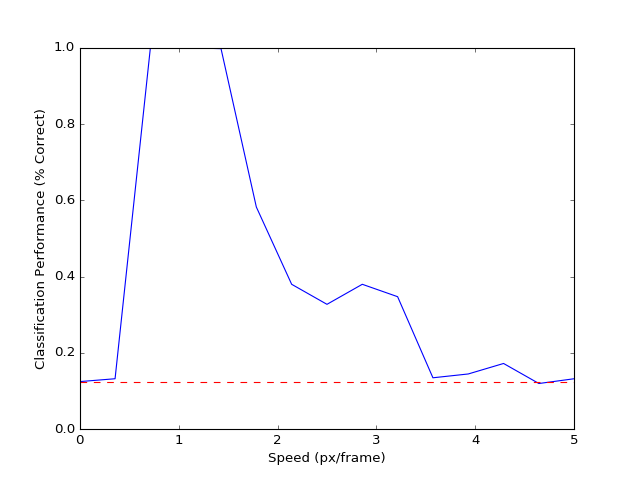

<IPython.core.display.Javascript object>


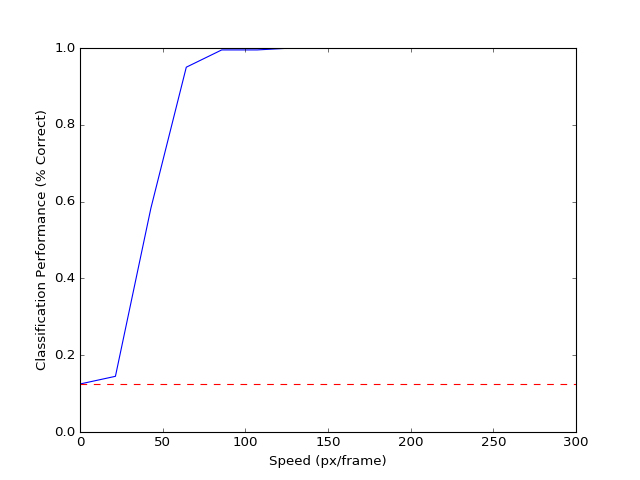

In [17]:
reps = 5
coh_data = validate_model(best_model,reps,(1,1,150))

In [72]:
from assets.keras.keras import backend as K
import copy

# working on gradient from: http://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

nb_c = [3,3,3]
nb_p = [2,2]
nb_f = [4,4,4]
input_img = K.placeholder((1,1, 16, 32, 32))

model = Sequential()
first_layer = ZeroPadding3D((0,1,1),input_shape=(1,16,32,32))
first_layer.input = input_img
model.add(first_layer)
model.add(Convolution3D(nb_f[0],len_conv_dim1=1, len_conv_dim2=nb_c[0], len_conv_dim3=nb_c[0], border_mode='valid',
                         activation='relu', dim_ordering='th',name='LGN'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, nb_p[0], nb_p[0])))
#model.add(Dropout(0.5))
model.add(ZeroPadding3D((1,1,1)))
model.add(Convolution3D(nb_f[1],len_conv_dim1=nb_c[1], len_conv_dim2=nb_c[1], len_conv_dim3=nb_c[1], border_mode='valid',
                        activation='relu', name='V1'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(nb_p[1], nb_p[1], nb_p[1])))
#model.add(Dropout(0.5))
#model.add(ZeroPadding3D((1,1,1)))
model.add(Convolution3D(nb_f[2],len_conv_dim1=nb_c[2], len_conv_dim2=nb_c[2], len_conv_dim3=nb_c[2], border_mode='valid',
                        activation='relu', name='MT'))
model.add(BatchNormalization())

# IGNORE LAST LAYERS
#model.add(Flatten())
##model.add(Dropout(0.5))
##model.add(Dense(4, init='normal', activation='relu', W_regularizer=l2(reg)))
#model.add(Dense(nb_classes, init='normal', W_regularizer=l2(r)))
#model.add(Activation('softmax'))

layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [73]:
# Copy model weights from best_model --> model
for li in range(len(model.layers)):
    model.layers[li].set_weights(best_model.layers[li].get_weights())
    

Exception: Layer weight shape (64,) not compatible with provided weight shape (32,).

In [68]:
layer_name = 'MT'
filter_index = 1  # can be any integer from 0 to 511, as there are 512 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].get_output()
loss = K.mean(layer_output[:, filter_index, :, :])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

In [69]:
step = 1000
# we start from a gray image with some noise
input_img_data = np.random.random((1, 1, 16, 32, 32)) * 20 + 128.
print np.min(input_img_data)
print np.max(input_img_data)
# run gradient ascent for 20 steps
for i in range(100):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
print np.min(input_img_data)
print np.max(input_img_data)

128.000371773
147.999938544
-125782.404263
165516.896124


In [39]:
print input_img_data.shape

(1, 1, 16, 32, 32)


In [70]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

img = input_img_data[0,0,:,:,:]
img = deprocess_image(img)

<IPython.core.display.Javascript object>


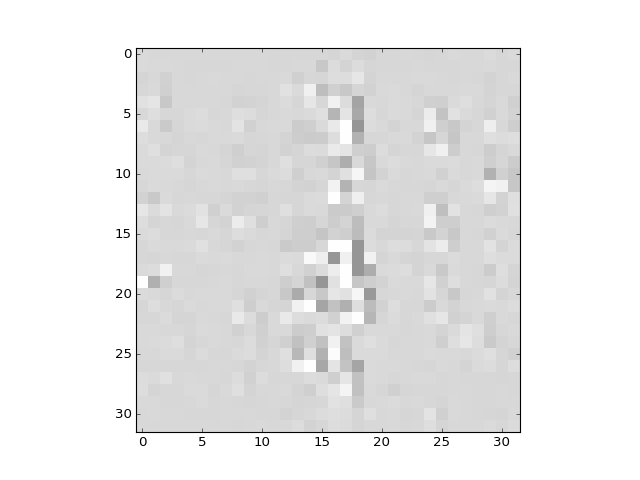

In [71]:
visualize_matrix(img,interval_len=50,ubound=255)